In [8]:
!pip install tk_tools

In [1]:
import tkinter as tk
import numpy as np
import pyaudio
import tk_tools
from numpy.polynomial import Polynomial
from scipy.signal import bilinear, lfilter

CHUNKS = [4096, 9600]
CHUNK = CHUNKS[1]
FORMAT = pyaudio.paInt16
CHANNEL = 1
RATES = [44100, 48000]
RATE = RATES[1]


def A_weighting(fs: float) -> tuple[np.ndarray, np.ndarray]:
    f1 = 20.598997
    f2 = 107.65265
    f3 = 737.86223
    f4 = 12194.217
    a1000 = 1.9997

    nums = Polynomial(((2*np.pi * f4)**2 * 10**(a1000 / 20), 0,0,0,0))
    dens = (
        Polynomial((1, 4*np.pi * f4, (2*np.pi * f4)**2)) *
        Polynomial((1, 4*np.pi * f1, (2*np.pi * f1)**2)) *
        Polynomial((1, 2*np.pi * f3)) *
        Polynomial((1, 2*np.pi * f2))
    )
    return bilinear(nums.coef, dens.coef, fs)


def rms_flat(a: np.ndarray) -> float:
    return np.sqrt(a.dot(a) / len(a))


class Meter:
    def __init__(self) -> None:
        self.pa = pyaudio.PyAudio()
        self.stream = self.pa.open(
            format=FORMAT,
            channels=CHANNEL,
            rate=RATE,
            input=True,
            frames_per_buffer=CHUNK,
        )
        self.numerator, self.denominator = A_weighting(RATE)
        self.max_decibel = 0

    def __enter__(self) -> 'Meter':
        return self

    def __exit__(self, exc_type, exc_val, exc_tb) -> None:
        self.stream.stop_stream()
        self.stream.close()
        self.pa.terminate()

    def listen(self, offset: int) -> float:
        block = self.stream.read(CHUNK)
        decoded_block = np.frombuffer(block, dtype=np.int16)
        y = lfilter(self.numerator, self.denominator, decoded_block)
        new_decibel = 20*np.log10(rms_flat(y)) + offset
        self.max_decibel = max(self.max_decibel, new_decibel)
        
        return new_decibel


class GUI:
    def __init__(self, meter: Meter) -> None:
        self.meter = meter

        self.root = root = tk.Tk()
        root.title('Decibel Meter')
        root.grid()
        root.grid_rowconfigure(index=0, weight=1)
        root.grid_rowconfigure(index=1, weight=1)
        root.grid_columnconfigure(index=0, weight=1)
        root.grid_columnconfigure(index=3, weight=1)
        root.protocol('WM_DELETE_WINDOW', self.close)
        self.app_closed = False

        self.gaugedb = tk_tools.RotaryScale(root, max_value=120, unit=' dBA')
        # This control does not respect resizing via tk.NSEW.
        self.gaugedb.grid(row=0, column=0, rowspan=2, sticky=tk.E)

        self.maxdb_display = tk_tools.SevenSegmentDigits(root, digits=3, digit_color='#00ff00', background='black')
        self.maxdb_display.grid(row=0, column=1, sticky=tk.S, padx=5)
        tk.Label(root, text='Max').grid(row=1, column=1, sticky=tk.N, padx=5)

        self.led = tk_tools.Led(root, size=50)
        self.led.to_red(on=False)
        self.led.grid(row=0, column=2, sticky=tk.S, padx=5)
        tk.Label(root, text='Too Loud').grid(row=1, column=2, sticky=tk.N, padx=5)

        self.offset = tk.IntVar(root, value=0, name='offset')
        spinbox = tk.Spinbox(root, from_=-20, to=20, textvariable=self.offset, state='readonly', width=12)
        spinbox.grid(row=0, column=3, sticky=tk.SW, padx=5)
        tk.Label(root, text='Calibration (dB)').grid(row=1, column=3, sticky=tk.NW, padx=5)

    def close(self) -> None:
        self.app_closed = True

    def run(self) -> None:
        while not self.app_closed:
            new_decibel = self.meter.listen(self.offset.get())
            self.update(new_decibel, self.meter.max_decibel)
            self.root.update()

    def update(self, new_decibel: float, max_decibel: float) -> None:
        self.gaugedb.set_value(np.around(new_decibel, 1))
        self.maxdb_display.set_value(f'{max_decibel:.1f}')
        self.led.to_red(on=new_decibel > 85)


def main() -> None:
    with Meter() as meter:
        gui = GUI(meter)
        gui.run()


if __name__ == '__main__':
    main()

[  0.           0.          -0.23430179 ... -26.72556953 -50.36816179
 -50.56671279]
[  -3.74882868  -19.63652734  -28.7860489  ... -120.43085733 -160.56160804
 -220.17579578]
[ 201.73384317  685.17584813  952.12280835 ... -180.17131202 -142.4990749
  -15.33527127]
[  76.1480825   221.82266981  219.12242833 ... -178.97912795 -140.09721653
  -71.10551951]
[  64.66729467  247.00094495  382.92145264 ... -122.76516177  -44.3371385
  -56.49568395]
[ 45.45454771 271.30517307 463.99076036 ...  23.29444177  48.42507333
  -1.2365165 ]
[ 102.85848682  209.61248846  256.98580359 ... -183.95843996 -237.89795523
 -308.73891971]
[ 209.46580232  652.07613526  928.38783029 ... -199.50413101 -204.02925573
 -120.98742058]
[ 125.58576067  360.72899329  488.97201437 ...  -67.07181314 -125.06279866
  -89.29802135]
[ 228.44424749  749.34805107 1044.30955821 ...  -55.98263856  -54.87951036
  -21.06740098]
[ 232.19307617  669.40631669  908.37126701 ...  -85.14846859 -174.57473981
 -235.42050276]
[ 266.6354396

KeyboardInterrupt: 

In [36]:
import numpy as np
import pyaudio
from numpy.polynomial import Polynomial
from scipy.signal import bilinear, lfilter
import librosa

data = 'data/4차년도/5e27f90b5807b852d9e0157b.wav'
y, sr = librosa.load(data,16000)

C:\Users\y2657\AppData\Local\Temp\ipykernel_16480\844480076.py:8: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y, sr = librosa.load(data,16000)


In [2]:
print(y)

[0.         0.         0.         ... 0.00102864 0.00112351 0.00130197]


In [7]:
test = np.frombuffer(y, dtype = np.int16)

In [19]:
f1 = 20.598997
f2 = 107.65265
f3 = 737.86223
f4 = 12194.217
a1000 = 1.9997

nums = Polynomial(((2*np.pi * f4)**2 * 10**(a1000 / 20), 0,0,0,0))
dens = (
    Polynomial((1, 4*np.pi * f4, (2*np.pi * f4)**2)) *
    Polynomial((1, 4*np.pi * f1, (2*np.pi * f1)**2)) *
    Polynomial((1, 2*np.pi * f3)) *
    Polynomial((1, 2*np.pi * f2)))
a = bilinear(nums.coef, dens.coef, 48000)

In [30]:
y = y.astype(np.int16)

In [31]:
b = lfilter(nums.coef, dens.coef, y)

In [34]:
new_decibel = 20*np.log10(rms_flat(b))

C:\Users\y2657\AppData\Local\Temp\ipykernel_16480\128507497.py:1: RuntimeWarning: divide by zero encountered in log10
  new_decibel = 20*np.log10(rms_flat(b))


In [12]:
def rms_flat(a: np.ndarray) -> float:
    return np.sqrt(a.dot(a) / len(a))

In [5]:
data = 'data/4차년도/5e27f90b5807b852d9e0157b.wav'
y, sr = librosa.load(data,sr = 16000)

In [1]:
import librosa
import numpy as np

In [13]:
def compute_power_db(x, sr, win_len_sec=0.1, power_ref=10**(-6)):
    win_len = round(win_len_sec * sr)
    print(win_len)
    win = np.ones(win_len) / win_len
    print(win)
    power_db = 10 * np.log10(np.convolve(x**2, win, mode='same') / power_ref)
    return power_db

In [14]:
power_db = compute_power_db(x=y, sr=sr)

1600
[0.000625 0.000625 0.000625 ... 0.000625 0.000625 0.000625]


C:\Users\y2657\AppData\Local\Temp\ipykernel_15804\3944047039.py:6: RuntimeWarning: divide by zero encountered in log10
  power_db = 10 * np.log10(np.convolve(x**2, win, mode='same') / power_ref)


In [15]:
y

array([0.        , 0.        , 0.        , ..., 0.00102864, 0.00112351,
       0.00130197], dtype=float32)

In [86]:
d = []
for i in range(y_len):
    db_max = power_db[i*sr:(i+1)*sr]
    db_max = np.max(db_max)
    d.append(int(db_max))
    
d

[8, 9, 12, 42, 34, 11, 22, 39, 35, 36, 11]

In [42]:
import matplotlib.pyplot as plt

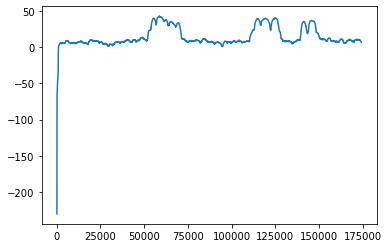

In [75]:
plt.plot(power_db)
# plt.ylim([50,110])
plt.show()